In [1]:

import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


FileExistsError: [Errno 17] File exists: 'data/positive'

In [5]:
!tar -xf lfw.tgz

tar: Error opening archive: Failed to open 'lfw.tgz'


In [6]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [7]:

import uuid

In [8]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/7af1d238-58da-11ef-94e5-5e961374456a.jpg'

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame [400:400+250, 900:900+250, : ]
    
    # for anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # for positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

2024-08-13 00:11:28.559 Python[50758:2926323] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'data/anchor/dfbd1d02-4f3f-11ef-94bf-5e961374456a.jpg'


In [132]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [133]:
img = preprocess('data/anchor/7277e2f4-4f3f-11ef-94bf-5e961374456a.jpg')

In [15]:
img.numpy().max() 

1.0

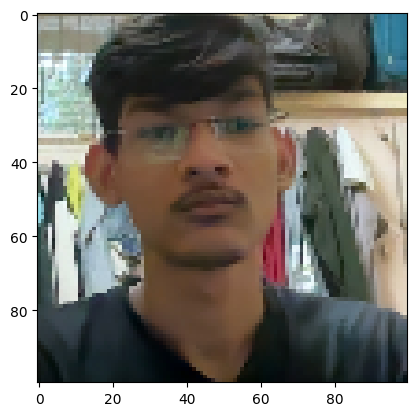

In [16]:
plt.imshow(img)


In [17]:

dataset = dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [20]:
samples = data.as_numpy_iterator()

In [21]:
example = samples.next()

In [22]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
res = preprocess_twin(*example)

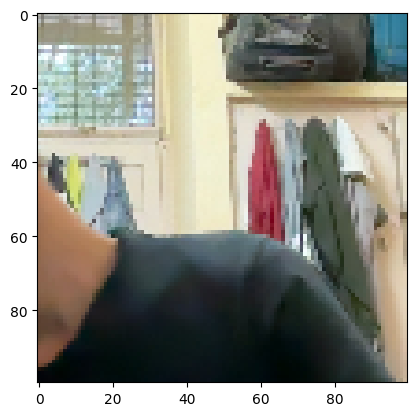

In [24]:
plt.imshow(res[0])

In [25]:
#dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [26]:

# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [27]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [28]:
inp = Input(shape=(100,100,3), name='input_image')

In [29]:
c1 = Conv2D(64,(10,10), activation='relu')(inp)

In [30]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [31]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [32]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [33]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [34]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:

mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [37]:
embedding = make_embedding()

In [38]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:

# Siamese L1 Distance class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    #norm of diff of x1 and x2
    #input_embedding is the x1 vector
    #validation_embedding is the x2 vector
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [40]:
# Siamese L1 Distance class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)
    #norm of diff of x1 and x2
    #input_embedding is the x1 vector
    #validation_embedding is the x2 vector
    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
    
        return tf.math.abs(input_embedding - validation_embedding)

    def  compute_output_shape(self, input_shape):
        return input_shape[0]

In [41]:
tf.reshape

<function tensorflow.python.ops.array_ops.reshape(tensor, shape, name=None)>

In [42]:
l1 = L1Dist()

In [43]:
l1

<L1Dist name=l1_dist, built=False>

In [44]:

input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [45]:

inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [46]:
siamese_layer = L1Dist()

In [47]:
distances = siamese_layer(inp_embedding, val_embedding)

In [48]:
classifier = Dense(1, activation='sigmoid')(distances)

In [49]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [50]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [51]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    
    #In this we are passing our input and validation image to embedding function
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_model = make_siamese_model()

In [54]:
# here there are the dimesnsions of the output layers 
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
binary_cross_loss = tf.losses.BinaryCrossentropy() # loss function

In [56]:

opt = tf.keras.optimizers.Adam(1e-4)  # optimizers

In [57]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [58]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [59]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [60]:
import tensorflow as tf

# Define your Siamese model
# Assuming `siamese_model` is already defined

# Loss function
binary_cross_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the training step function
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        anchor = batch[0]  # First input tensor (e.g., anchor image)
        positive_or_negative = batch[1]  # Second input tensor (e.g., positive or negative image)
        y = tf.expand_dims(batch[2], axis=-1)  # Ensure `y` has the shape (batch_size, 1)
        
        # Get the model output
        yhat = siamese_model([anchor, positive_or_negative], training=True)
        
        # Reshape yhat to match the shape of y
        yhat = tf.reshape(yhat, tf.shape(y))
        
        # Calculate the loss
        loss = binary_cross_loss(y, yhat)
    
    # Print the loss (for debugging purposes)
    print(loss)
    
    # Calculate the gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Apply the gradients to the optimizer
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))

# Training function
def train(data, EPOCHS):
    for epoch in range(EPOCHS):
        print(f'Starting epoch {epoch+1}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx + 1)
        # Save checkpoints if needed

# Define your optimizer
optimizer = tf.keras.optimizers.Adam()

# Assume train_data is your preprocessed dataset
train(train_data, EPOCHS=50)



Starting epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step
Starting epoch 2/50


2024-08-13 00:13:03.233550: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step
Starting epoch 3/50


2024-08-13 00:14:27.452053: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step
Starting epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step
Starting epoch 5/50


2024-08-13 00:16:54.951877: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Starting epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step
Starting epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step
Starting epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 9/50


2024-08-13 00:21:55.712259: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step
Starting epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step
Starting epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step
Starting epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step
Starting epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step
Starting epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step
Starting epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step
Starting epoch 17/50


2024-08-13 00:32:32.639514: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step
Starting epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step
Starting epoch 19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step
Starting epoch 20/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step
Starting epoch 21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step
Starting epoch 22/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 23/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Starting epoch 24/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step
Starting epoch 25/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step
Starting epoch 26/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step
Starting epoch 27/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 28/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 29/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Starting epoch 30/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Starting epoch 31/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 32/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 33/50


2024-08-13 00:53:17.565800: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Starting epoch 34/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Starting epoch 35/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Starting epoch 36/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 37/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 38/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 39/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Starting epoch 40/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 41/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Starting epoch 42/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step
Starting epoch 43/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Starting epoch 44/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 45/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
Starting epoch 46/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step
Starting epoch 47/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step
Starting epoch 48/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step
Starting epoch 49/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step
S

In [61]:
from tensorflow.keras.metrics import Precision, Recall

In [62]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [63]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


array([[[0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657]]], dtype=float32)

In [65]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [66]:
y_true

array([0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [67]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

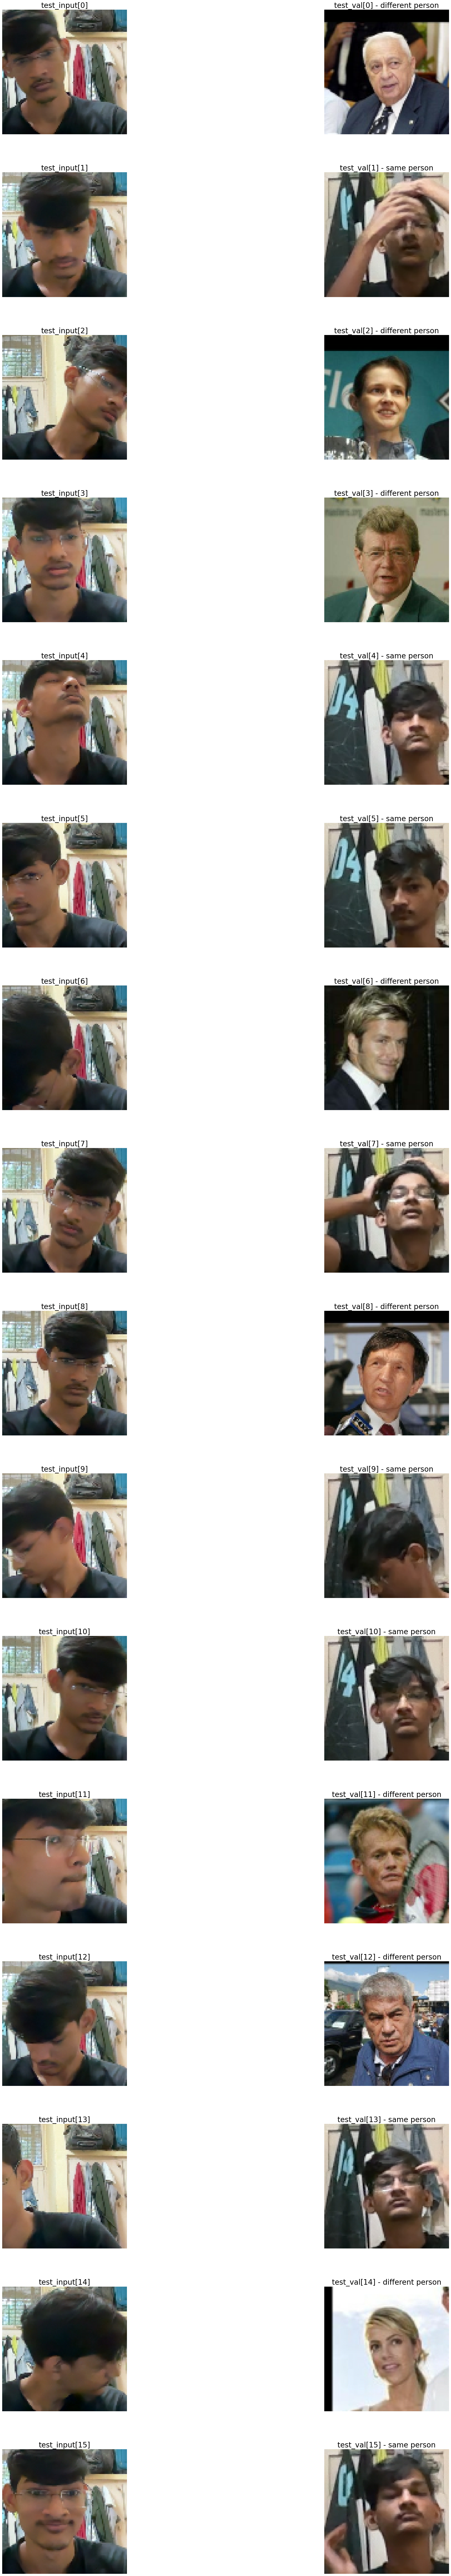

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 120))

for i in range(len(y_true)):
    plt.subplot(16, 2, 2 * i + 1)
    plt.imshow(test_input[i])
    plt.axis('off')
    plt.title(f'test_input[{i}]', fontsize=24)

    plt.subplot(16, 2, 2 * i + 2)
    plt.imshow(test_val[i])
    plt.axis('off')
    result = 'same person' if y_true[i] == 1.0 else 'different person'
    plt.title(f'test_val[{i}] - {result}', fontsize=24)

plt.tight_layout(pad=10.0)
plt.show()

In [69]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [70]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [71]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


array([[[0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657],
        [0.35998657]]], dtype=float32)

In [72]:
# model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

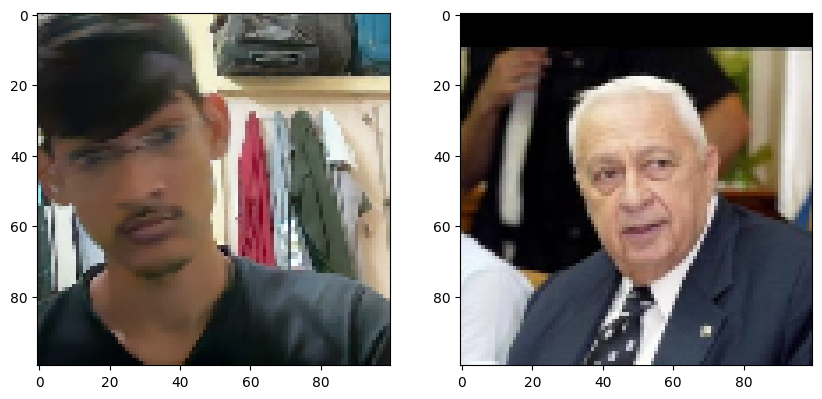

In [73]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [118]:
application_data = "application_data\\verification_images"

In [119]:
os.listdir(os.path.join('application_data', 'verification_images'))

['4fa38a54-4f4d-11ef-8db4-5e961374456a.jpg',
 '0cf760ae-4f4d-11ef-8db4-5e961374456a.jpg',
 '49471252-4f4d-11ef-8db4-5e961374456a.jpg',
 'fa8a6704-4f4c-11ef-8db4-5e961374456a.jpg',
 '5d64f970-4f4d-11ef-8db4-5e961374456a.jpg',
 '5951d4fc-4f4d-11ef-8db4-5e961374456a.jpg',
 'ec11c7a8-4f4c-11ef-8db4-5e961374456a.jpg',
 '31db67f8-4f4d-11ef-8db4-5e961374456a.jpg',
 '141579d4-4f4d-11ef-8db4-5e961374456a.jpg',
 '20a5901c-4f4d-11ef-8db4-5e961374456a.jpg',
 '.DS_Store',
 'ecdd4680-4f4c-11ef-8db4-5e961374456a.jpg',
 '5a2b4598-4f4d-11ef-8db4-5e961374456a.jpg',
 '1f031d88-4f4d-11ef-8db4-5e961374456a.jpg',
 '0ef49926-4f4d-11ef-8db4-5e961374456a.jpg',
 '32330986-4f4d-11ef-8db4-5e961374456a.jpg',
 '31cd387c-4f4d-11ef-8db4-5e961374456a.jpg',
 '4d276e8a-4f4d-11ef-8db4-5e961374456a.jpg',
 '271165f2-4f4d-11ef-8db4-5e961374456a.jpg',
 '5a1d56b8-4f4d-11ef-8db4-5e961374456a.jpg',
 '4688e3c4-4f4d-11ef-8db4-5e961374456a.jpg',
 'eb5fb6d0-4f4c-11ef-8db4-5e961374456a.jpg',
 '487a3a02-4f4d-11ef-8db4-5e961374456a.jp

In [120]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [114]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/4fa38a54-4f4d-11ef-8db4-5e961374456a.jpg
application_data/verification_images/0cf760ae-4f4d-11ef-8db4-5e961374456a.jpg
application_data/verification_images/49471252-4f4d-11ef-8db4-5e961374456a.jpg
application_data/verification_images/fa8a6704-4f4c-11ef-8db4-5e961374456a.jpg
application_data/verification_images/5d64f970-4f4d-11ef-8db4-5e961374456a.jpg
application_data/verification_images/5951d4fc-4f4d-11ef-8db4-5e961374456a.jpg
application_data/verification_images/ec11c7a8-4f4c-11ef-8db4-5e961374456a.jpg
application_data/verification_images/31db67f8-4f4d-11ef-8db4-5e961374456a.jpg
application_data/verification_images/141579d4-4f4d-11ef-8db4-5e961374456a.jpg
application_data/verification_images/20a5901c-4f4d-11ef-8db4-5e961374456a.jpg
application_data/verification_images/.DS_Store
application_data/verification_images/ecdd4680-4f4c-11ef-8db4-5e961374456a.jpg
application_data/verification_images/5a2b4598-4f4d-11ef-8db4-5e961374456a.jpg
application_data/

In [121]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [139]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame [400:400+250, 900:900+250, : ]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


InvalidArgumentError: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]

NameError: name 'results' is not defined

In [ ]:
frame = frame [400:400+250, 900:900+250, : ]